## Modeling the Energy Demand for DAC Packed Bed Systems

In [2]:
# Packages:
import numpy as np
from numpy import exp
import pandas as pd
import math

import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
from fipy import CellVariable, FaceVariable, Grid1D, TransientTerm, DiffusionTerm, ConvectionTerm


In [3]:
# Data Sets:
HousData = pd.read_csv('HoustonClimateData.csv') # hourly
PBRunStatus = pd.read_csv('DAC Run Scenarios/1yrRun_PBStampiBombelli.csv') # 10 min

# Expand climate data - assumes conditions within hour don't change
HousData_exp = HousData.loc[HousData.index.repeat(6)].reset_index(drop=True) # 10 min

print(HousData)
print(PBRunStatus)

      WindSpeed  SoilTemperature  AirTemperature   Radiation  SpecificHumidity
0      8.070086       289.373413      287.725281    0.000000          0.008639
1      8.185447       288.695312      287.377014    0.000000          0.008467
2      7.539393       288.091400      286.852112    0.000000          0.008555
3      7.047758       287.534851      285.859131    0.000000          0.008742
4      6.486834       287.088898      285.580261    0.000000          0.008990
...         ...              ...             ...         ...               ...
8755        NaN       286.576965      293.150391  594.500000          0.007796
8756        NaN       287.609894      293.634216  485.750000          0.007903
8757        NaN       288.276459      293.534821  325.500000          0.008079
8758        NaN       288.426178      292.625427  138.375000          0.009105
8759        NaN       287.778259      289.126160    7.400391          0.009399

[8760 rows x 5 columns]
              hour  minute 

In [4]:
## Functions:
# Functions to calculate work (W); Stampi-Bombelli Paper
def fan_work(eta_fan, V_flow, P_drop, t_fan):
    W_fan = (1 / eta_fan) * V_flow * (P_drop) * t_fan
    return W_fan

def comp_work(eta_comp, n, R, T, pH, pL, t_comp):
    W_comp = (1 / eta_comp) * n * R * T * np.log(pH / pL) * t_comp
    return W_comp

def total_work(W_comp, W_fan):
    W_total = W_comp + W_fan
    return W_total
    
# Function to calculate heat transfer (Q); Stampi-Bombelli Paper
def heat_transfer(h_W, Twf, Tw, r, L, t_heat):
    Q = h_W * (Twf - Tw) * 2 * np.pi * r * L * t_heat
    return Q

# Function to calculate Relative Humidity from Specific Humidity
def get_RH(Temp, SpecHum):
    Ps = 611.3 * math.e ** (5417.1 * (1 / 273.15 - 1 / Temp)) #Saturation Vapor Pressure (Clausius-Clapeyron equation)
    RH = 100 * (SpecHum * 461.5 * Temp / Ps)
    return RH

# Inputs to Toth Equation:
def ns(T): # S2 Stampi-Bombelli
    return ns0 * np.exp(chi * (1 - T / T0))
    
def b(T): # S3 Stampi-Bombelli
    return b0 * np.exp((deltaH0 / (R_mol * T0)) * ((T0 / T) - 1))

def t(T): # S4 Stampi-Bombelli
    return t0 + alpha * (1 - T0 / T) 

# Toth Equation:
def find_q_star(p_CO2, T): # S1 Stampi-Bombelli
    ns_val = ns(T)
    b_val = b(T)
    t_val = t(T)
    numerator = ns_val * b_val * p_CO2
    denominator = (1 + (b_val * p_CO2)**t_val)**(1 / t_val)
    return numerator / denominator # mol capacity CO2 / kg sorbent

def q_star_func(c_val):
    p_CO2 = c_val * R_mol * Tc / 1000  # mol/m3 to kPa
    q_mass = find_q_star(p_CO2, Tc)  # mol/kg
    return q_mass * rho_bed * psi # mol/m3


In [5]:
## Variables & Inputs:
# Climate Data Inputs
TempsHourly = HousData_exp['AirTemperature'].values # K
SpecHumidity = HousData_exp['SpecificHumidity'].values # kg/m3
Tc = 298 # K, constant temperature

# System Variables
v = 0.8 #m/s Average feed velocity, Stampi-Bombelli et al
mu = CP.PropsSI('V','P',101325,'T',TempsHourly,'air') #Pa*s gaseous dynamic viscosity
mu_c = CP.PropsSI('V','P',101325,'T',Tc,'air') #Pa*s constant viscosity

rho = CP.PropsSI('D','P',101325,'T',TempsHourly,'air') #kg/m3 density of dry air
rho_c = CP.PropsSI('D','P',101325,'T',Tc,'air') #kg/m3 constant density

Twf = 373.15  # K, Heat of regeneration
Tw = TempsHourly # K, Column wall temperature (this is outdoor temperature)

R = 287 #J/kg(air)*K
R_CO2 = 188.92 # J/kg*K
R_mol = 8.314 # J/mol·K
T = TempsHourly  # K, Air temperature

pH = 100000 # Pa, Inital pressure (1 bar)
pL = 1000  # Pa, Vacuum pressure (Stampi-Bombelli)

eta_fan = 0.5  # Efficiency of blower; Stampi-Bombelli
eta_comp = 0.3  # Efficiency of compressor; Stampi-Bombelli


In [6]:
# Packed Bed Scenario: Stampi-Bombelli Paper
dp = 0.001 # m, range from 1-5mm, pellet size
rp = dp/2 # m, pellet radius
rho_s = 3600 # kg/m3, Material density TRI-al
rho_p = 1044 # kg/m3, Particle density TRI-al (pellets are porous)

L = 0.40 # m, 40cm (or 8 5cm beds in parallel)
D = 0.04 # m
r = D/2 # m, radius
V = np.pi * r**2 * L # m3, volume(cylinder)
epsilon = 0.39 + 1.74/((D/dp + 1.14)**2) # bed porosity
psi = 1 # 1 for 40 cm single bed, 0.4 for 5cm beds in series.
u = v / epsilon # m/s interstitial velocity
rho_bed = rho_p*(1-epsilon) # kg/m^3, bed density
h_L = 26 # W/K*m2, wall-ambient heat transfer coefficient
h_W = 10 # W/K*m2, column wall heat transfer coefficient


In [7]:
# Packed Bed CO2 adsorption equilibrium:
T0 = 298 # K, reference temperature for Toth parameters
ns0 = 1.067 # mol/kg Toth sorbent maximum capacity at reference temperature
b0 = 93.89 # 1/kPa Toth affinity coefficient at reference temperature
t0 = 0.461 # Toth exponent (heterogeneity parameter) at reference temperature

deltaH0 = 70000 # J/mol isosteric heat of adsorption (how much energy is released when CO2 binds to sorbent) (exothermic) Grossmann et al 

chi = 6.49E-13 # Temperature adjustment factor for ns(T) (0 means no temperature dependence of maximum capacity)
alpha = 0.708 # Temperature adjustment factor for t(T)

CO2_conc = 430 # ppm
pCO2_air = pH/1000 * (CO2_conc/1000000) # kPa
c_CO2 = (pCO2_air * 1000) / (R_mol * T) # mol/m3
c_CO2_c = (pCO2_air * 1000) / (R_mol * Tc) # mol/m3

q_star_ads = find_q_star(pCO2_air, T)
q_star_ads_c = find_q_star(pCO2_air, Tc)

pCO2_des = 1 # KPa "CO2 is the only species desorbing during regeneration, its molar fraction rapidly reaches 1, with its partial pressure matching the vacuum level." - Stampi-Bombelli
q_star_des = find_q_star(pCO2_des, 373.15)

deltaq_star = q_star_ads - q_star_des


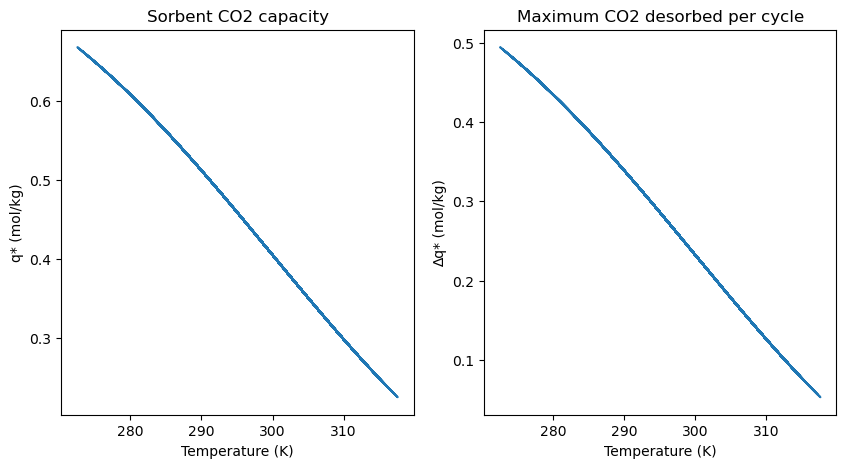

In [8]:
# Plotting q* curves ∆q*
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(T, q_star_ads)

plt.ylabel('q* (mol/kg)')
plt.xlabel('Temperature (K)')
plt.title('Sorbent CO2 capacity')

plt.subplot(1, 2, 2)
plt.plot(T, deltaq_star)

plt.ylabel('∆q* (mol/kg)')
plt.xlabel('Temperature (K)')
plt.title('Maximum CO2 desorbed per cycle')
plt.show()

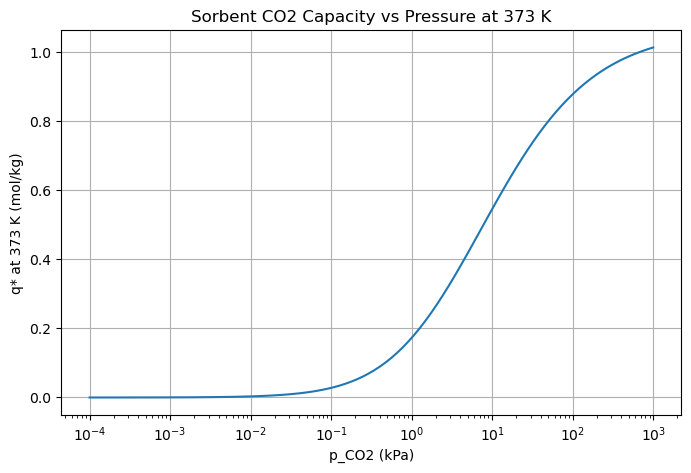

In [9]:
# Plotting q* at different pressures
pressures = np.logspace(-4, 3, 100)  # from 0.0001 to 1.0 kPa
q_des_curve = [find_q_star(p, 373.15) for p in pressures]

plt.figure(figsize=(8, 5))
plt.plot(pressures, q_des_curve)
plt.xscale('log')
plt.xlabel("p_CO2 (kPa)")
plt.ylabel("q* at 373 K (mol/kg)")
plt.title("Sorbent CO2 Capacity vs Pressure at 373 K")
plt.grid(True)
plt.show()

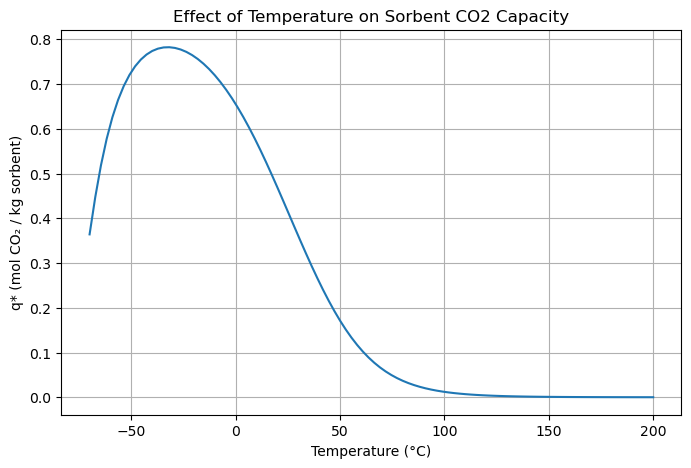

In [10]:
# Plotting q* with wide range of Temperatures
T_range = np.linspace(203.15, 473.15, 100)  # from 0°C to 100°C
q_vs_T = [find_q_star(0.04, T) for T in T_range]  # 400 ppm CO2

plt.figure(figsize=(8, 5))
plt.plot(T_range - 273.15, q_vs_T)
plt.xlabel("Temperature (°C)")
plt.ylabel("q* (mol CO₂ / kg sorbent)")
plt.title("Effect of Temperature on Sorbent CO2 Capacity")
plt.grid(True)
plt.show()

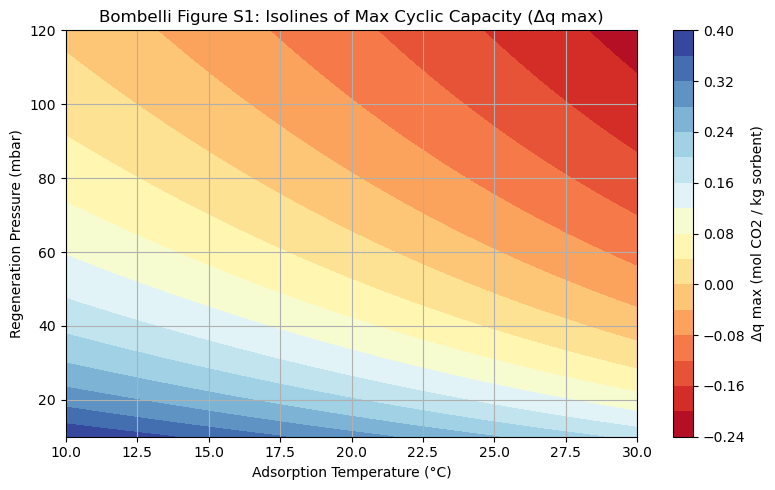

In [11]:
# Replication of Figure S1 Stampi-Bombelli paper
# Temperature and pressure ranges
T_ads_range = np.linspace(283.15, 303.15, 100)  # 10°C to 30°C in Kelvin
pL_range_mbar = np.linspace(1, 12, 100)        # 1 to 120 mbar in kPa

T_ads_grid, pL_grid = np.meshgrid(T_ads_range, pL_range_mbar)

T_des = 373.15 

q_ads = find_q_star(0.04, T_ads_grid)
q_des = find_q_star(pL_grid, T_des)
delta_q = q_ads - q_des

plt.figure(figsize=(8, 5))
cp = plt.contourf(T_ads_grid - 273.15, pL_grid * 10, delta_q, levels=15, cmap="RdYlBu")
plt.colorbar(cp, label="Δq max (mol CO2 / kg sorbent)")
plt.xlabel("Adsorption Temperature (°C)")
plt.ylabel("Regeneration Pressure (mbar)")
plt.title("Bombelli Figure S1: Isolines of Max Cyclic Capacity (Δq max)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
#Transport Variables
Dm = 1.5e-5  # m2/s molecular diffusivity
D_TRI = 6e-7 # m2/s TRI-al diffusivity
tau = 3 # tortuosity

Re = rho_c * v * dp / mu_c # Reynolds number
Sc = mu_c / (rho_c * Dm) # Schmidt number

rc = 3.5e-10 # m crystalline radius Wefers & Misra 1987
ks = 15 * D_TRI / (rc**2)  # 1/s

# PB:
a = 3 / rp  # 1/m Specific surface area 
Sh = 2 + 1.1 * Re**0.6 * Sc**0.33 # Sherwood number
kf_prime = Dm / dp * Sh # m/s
kf = 3 /  rp * kf_prime  # 1/s

De_p = D_TRI  # m2/s Effective pore diffusivity in TRI-al
epsilon_p = 0.71
epsilon_star = epsilon + epsilon_p * (1-epsilon)

kp = 15 * epsilon_p * De_p / (rp**2)  # 1/s

DL = u * dp * ((0.45 + 0.55 * epsilon) / (Re * Sc) + 0.5)  # m2/s

qv_star = q_star_ads * rho_bed * psi # mol/m3 (mol/kg * kg/m3)
qv_star_c = q_star_ads_c * rho_bed * psi # mol/m3 (mol/kg * kg/m3)

k_inv = (1 / kf) * (qv_star_c / c_CO2_c) + (1 / kp) * (qv_star_c / c_CO2_c) + (1 / ks)
k = 1/k_inv


In [13]:
# Coupled PDE: Packed Bed

nx = 100 # number of spatial points
dx = L / nx
mesh = Grid1D(dx=dx, nx=nx) # use 1D grid to align with paper assumption


# Variables
c = CellVariable(name="Gas Concentration", mesh=mesh, value=0.0) # mol/m3 Gas phase concentration: initially 0 everywhere
q = CellVariable(name="Solid Loading", mesh=mesh, value=0.0) # mol/m3 Solid phase concentration: initially 0 everywhere


# Inlet CO2 concentration (mol/m3)
c_in = (pCO2_air * 1000) / (R_mol * Tc) # mol/m3

# Boundary conditions: Serna-Guerro paper
c.constrain(c_in, mesh.facesLeft) # CO2 inlet value fixed at ambient
c.faceGrad.constrain(0.0, mesh.facesRight) # zero concentration gradient at outlet

v_vector = FaceVariable(mesh=mesh, rank=1, value=v)

# PDE
mass_balance = (TransientTerm(coeff=epsilon_star, var=c)
                == DiffusionTerm(coeff=epsilon * DL, var=c)
                - ConvectionTerm(coeff=v_vector, var=c)
                - (1 - epsilon_star) * TransientTerm(var=q))


# Time loop
dt = 0.001
steps = 1000
x = mesh.cellCenters.value[0]
c_hist = [] # gas-phase CO2 concentration over time
q_hist = [] # solid-phase CO2 loading over time
time_hist = []
kg_hist   = [] # cumulative kg CO2 in column at each saved step
qgram_hist = [] # mmol/g profile snapshots (same cadence as c_hist)
occ_hist  = [] # average pore occupancy % snapshots


for step in range(steps):
    mass_balance.solve(var=c, dt=dt)
    q_star_val = q_star_func(c.value)
    q.setValue(q.value + k * (q_star_val - q.value) * dt)

    q_vol = q.value # mol/m3 CO2 in every cell
    mol_column = np.trapz(q_vol, x) * np.pi * r**2 # mol CO2 in whole column
    kg_column  = mol_column * 44.01 / 1000 # kg CO2
    kg_hist.append(kg_column)

    if step % 100 == 0:
        q_gram  = q_vol / rho_bed # mmol/g (mol/m3 / kg/m3 = mol/kg)
        qgram_hist.append(q_gram.copy())
        
        q_star_profile = q_star_func(c.value)
        occ_frac = (q_vol / q_star_profile) * 100 # pore occupancy %
        occ_hist.append(occ_frac.mean())

        c_hist.append(c.value.copy())
        q_hist.append(q.value.copy())
        time_hist.append(step * dt)
        

In [17]:
#np.savez('PB_SR.npz',q=q.value,c=c.value,c_hist=c_hist,q_hist=q_hist,time_hist=time_hist,kg_hist=kg_hist,qgram_hist=qgram_hist,occ_hist=occ_hist,x=x)
data_short = np.load('PB_SR.npz')
q = data_short['q']
c = data_short['c']
q_hist = data_short['q_hist']
c_hist = data_short['c_hist']
time_hist = data_short['time_hist']
kg_hist = data_short['kg_hist']
qgram_hist = data_short['qgram_hist']
occ_hist = data_short['occ_hist']
x = data_short['x']

In [18]:
# Courant–Friedrichs–Lewy (CFL) condition check
CFL = max(v * dt / dx, k * 2 * dt / dx**2)
print(f"CFL = {CFL:.4f}")


CFL = 0.2002


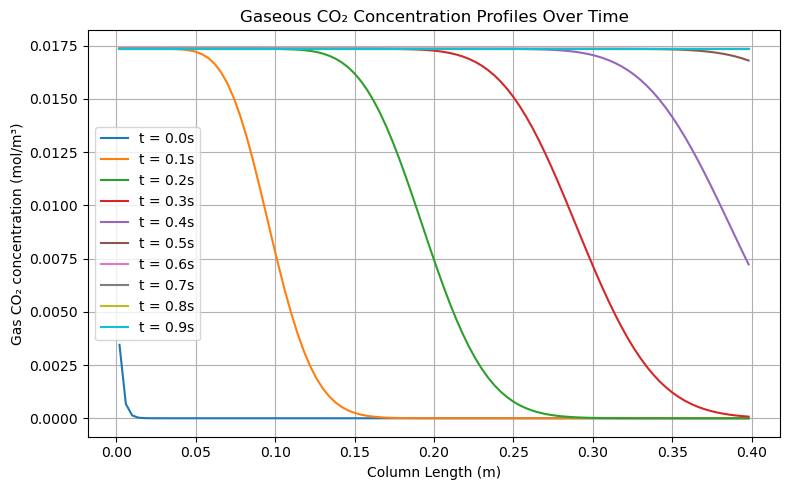

In [22]:
# c breakthrough profiles
plt.figure(figsize=(8, 5))
for i, time in enumerate(time_hist):
    plt.plot(x, c_hist[i], label=f't = {time:.1f}s')
plt.xlabel("Column Length (m)")
plt.ylabel("Gas CO₂ concentration (mol/m³)")
plt.title("Gaseous CO₂ Concentration Profiles Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


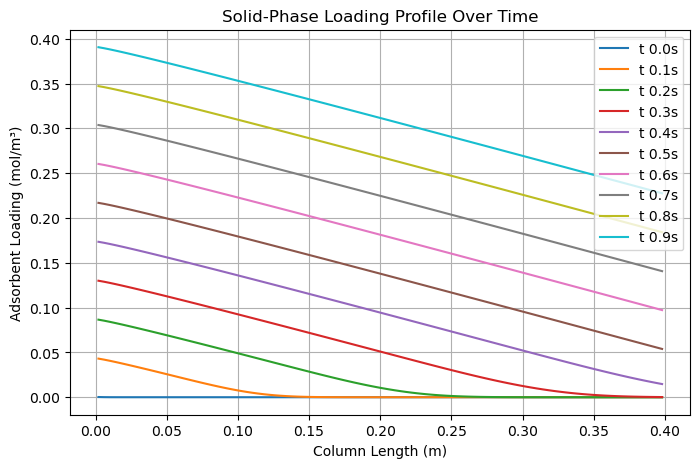

In [23]:
# q breakthrough profiles
dt = 0.001
plt.figure(figsize=(8, 5))
for i, profile in enumerate(q_hist):
    plt.plot(x, profile, label=f't {i*dt*100:.1f}s')
plt.xlabel("Column Length (m)")
plt.ylabel("Adsorbent Loading (mol/m³)")
plt.title("Solid-Phase Loading Profile Over Time")
plt.legend()
plt.grid(True)
plt.show()


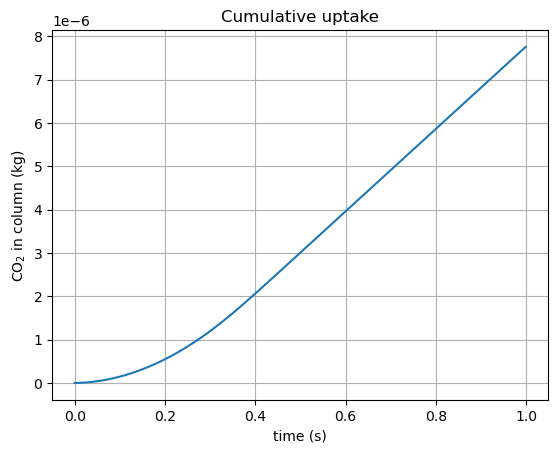

In [24]:
# Cumulative kg CO2 vs time
steps = 1000
t_fine = np.arange(steps) * dt        
plt.figure() 
plt.plot(t_fine, kg_hist)
plt.xlabel("time (s)")
plt.ylabel("CO$_2$ in column (kg)")
plt.title("Cumulative uptake")
plt.grid(True)

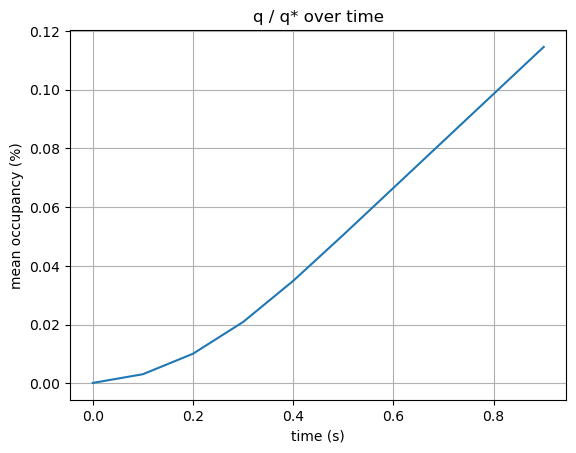

In [26]:
# Average pore-occupancy vs time
plt.figure()
plt.plot(time_hist, occ_hist)
plt.xlabel("time (s)")
plt.ylabel("mean occupancy (%)")
plt.title("q / q* over time")
plt.grid(True)

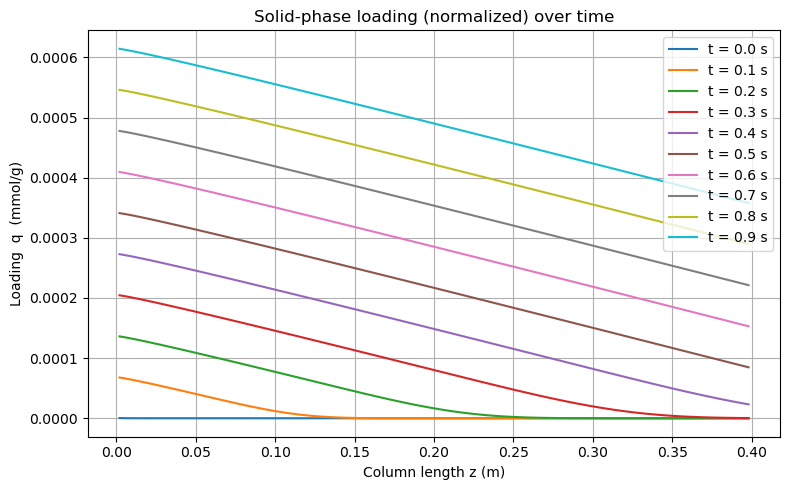

In [27]:
plt.figure(figsize=(8, 5))
for i, (profile_mm, t_snap) in enumerate(zip(qgram_hist, time_hist)):
    plt.plot(x, profile_mm, label=f't = {t_snap:.1f} s')
plt.xlabel("Column length z (m)")
plt.ylabel("Loading  q  (mmol/g)")
plt.title("Solid-phase loading (normalized) over time")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [32]:
# # Coupled PDE: Long Adsorption

# nxA= 20 # number of spatial points
# dxA = L / nxA
# meshA = Grid1D(dx=dxA, nx=nxA) # use 1D grid to align with paper assumption


# # Variables
# cA = CellVariable(name="Gas Concentration", mesh=meshA, value=0.0) # mol/m3 Gas phase concentration: initially 0 everywhere
# qA = CellVariable(name="Solid Loading", mesh=meshA, value=0.0) # mol/m3 Solid phase concentration: initially 0 everywhere


# # Inlet CO2 concentration (mol/m3)
# c_in = (pCO2_air * 1000) / (R_mol * Tc) # mol/m3

# # Boundary conditions: Serna-Guerro paper
# cA.constrain(c_in, meshA.facesLeft) # CO2 inlet value fixed at ambient
# cA.faceGrad.constrain(0.0, meshA.facesRight) # zero concentration gradient at outlet

# v_vectorA = FaceVariable(mesh=meshA, rank=1, value=v)

# # PDE
# mass_balanceA = (TransientTerm(coeff=epsilon_star, var=cA)
#                 == DiffusionTerm(coeff=epsilon * DL, var=cA)
#                 - ConvectionTerm(coeff=v_vectorA, var=cA)
#                 - (1 - epsilon_star) * TransientTerm(var=qA))


# # Time loop
# dtA = 0.025
# stepsA = 400000 #10,000 seconds adsorption time
# xA = meshA.cellCenters.value[0]
# c_histA = [] # gas-phase CO2 concentration over time
# q_histA = [] # solid-phase CO2 loading over time
# time_histA = []
# kg_histA   = [] # cumulative kg CO2 in column at each saved step
# qgram_histA = [] # mmol/g profile snapshots (same cadence as c_hist)
# occ_histA  = [] # average pore occupancy % snapshots


# for step in range(stepsA):
#     mass_balanceA.solve(var=cA, dt=dtA)
#     q_star_valA = q_star_func(cA.value)
#     qA.setValue(qA.value + k * (q_star_valA - qA.value) * dtA)

#     if step % 1000 == 0:
#         q_volA = qA.value # mol/m3 CO2 in every cell
#         mol_columnA = np.trapz(q_volA, xA) * np.pi * r**2 # mol CO2 in whole column
#         kg_columnA  = mol_columnA * 44.01 / 1000 # kg CO2
#         kg_histA.append(kg_columnA)
        
#         q_gramA  = q_volA / rho_bed # mmol/g (mol/m3 / kg/m3 = mol/kg)
#         qgram_histA.append(q_gramA.copy())
        
#         q_star_profileA = q_star_func(cA.value)
#         occ_fracA = (q_volA / q_star_profileA) * 100 # pore occupancy %
#         occ_histA.append(occ_fracA.mean())

#         c_histA.append(cA.value.copy())
#         q_histA.append(qA.value.copy())
#         time_histA.append(step * dtA)

# np.savez(
# "PB_long_adsorption.npz",
# q=qA.value,
# c=cA.value,
# c_hist=c_histA,
# q_hist=q_histA,
# time_hist=time_histA,
# kg_hist=kg_histA,
# qgram_hist=qgram_histA,
# occ_hist=occ_histA,
# x=xA,
# )       

In [33]:
data_long = np.load('PB_long_adsorption.npz')
qA = data_long['q']
cA = data_long['c']
q_histA = data_long['q_hist']
c_histA = data_long['c_hist']
time_histA = data_long['time_hist']
kg_histA = data_long['kg_hist']
qgram_histA = data_long['qgram_hist']
occ_histA = data_long['occ_hist']
xA = data_long['x']

In [34]:
# # Courant–Friedrichs–Lewy (CFL) condition check
# CFL_A = max(v * dtA / dxA, k * 2 * dtA / dxA**2)
# print(f"CFL = {CFL_A:.4f}")


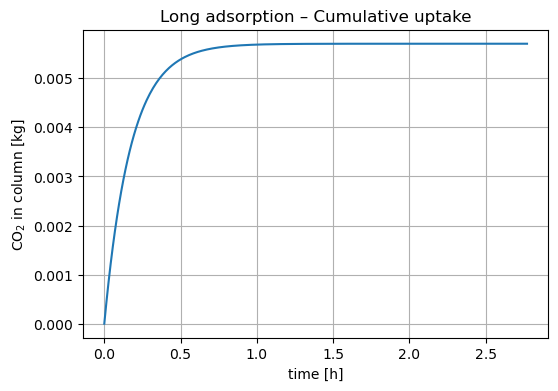

In [35]:
# Cumulative kg CO2 vs time
plt.figure(figsize=(6,4))
plt.plot(np.array(time_histA)/3600, kg_histA)
plt.xlabel("time [h]")
plt.ylabel("CO$_2$ in column [kg]")
plt.title("Long adsorption – Cumulative uptake")
plt.grid(True)

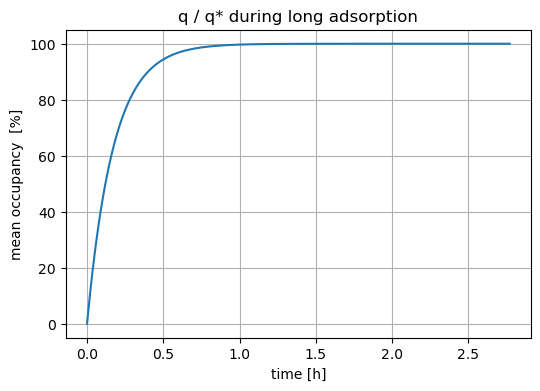

In [36]:
# Average pore-occupancy vs time
plt.figure(figsize=(6,4))
plt.plot(np.array(time_histA)/3600, occ_histA)
plt.xlabel("time [h]")
plt.ylabel("mean occupancy  [%]")
plt.title("q / q* during long adsorption")
plt.grid(True)


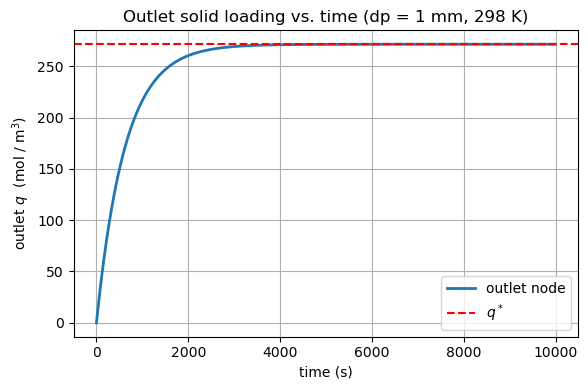

In [37]:
# Outlet node loading vs time
q_out  = np.array([profile[-1] for profile in q_histA])   # last cell = outlet
time_s = np.array(time_histA)
q_star_valA = q_star_func(cA)

plt.figure(figsize=(6,4))
plt.plot(time_s, q_out, lw=2, label="outlet node")

plt.axhline(q_star_valA[-1], ls="--", c="red", label=r"$q^*$")

plt.xlabel("time (s)")
plt.ylabel(r"outlet $q$  (mol / m$^{3}$)")
plt.title("Outlet solid loading vs. time (dp = 1 mm, 298 K)")
plt.legend(); plt.grid(True); plt.tight_layout()

In [38]:
# # Coupled PDE: Long Adsorption

# nxB= 20 # number of spatial points
# dxB = L / nxB
# meshB = Grid1D(dx=dxB, nx=nxB) # use 1D grid to align with paper assumption


# # Variables
# cB = CellVariable(name="Gas Concentration", mesh=meshB, value=0.0) # mol/m3 Gas phase concentration: initially 0 everywhere
# qB = CellVariable(name="Solid Loading", mesh=meshB, value=0.0) # mol/m3 Solid phase concentration: initially 0 everywhere


# # Inlet CO2 concentration (mol/m3)
# c_in = (pCO2_air * 1000) / (R_mol * Tc) # mol/m3

# # Boundary conditions: Serna-Guerro paper
# cB.constrain(c_in, meshB.facesLeft) # CO2 inlet value fixed at ambient
# cB.faceGrad.constrain(0.0, meshB.facesRight) # zero concentration gradient at outlet

# v_vectorB = FaceVariable(mesh=meshB, rank=1, value=v)

# # PDE
# mass_balanceB = (TransientTerm(coeff=epsilon_star, var=cB)
#                 == DiffusionTerm(coeff=epsilon * DL, var=cB)
#                 - ConvectionTerm(coeff=v_vectorB, var=cB)
#                 - (1 - epsilon_star) * TransientTerm(var=qB))


# # Time loop
# dtB = 0.025
# stepsB = 144000 #3,600 seconds adsorption time (1 hour)
# xB = meshB.cellCenters.value[0]
# c_histB = [] # gas-phase CO2 concentration over time
# q_histB = [] # solid-phase CO2 loading over time
# time_histB = []
# kg_histB   = [] # cumulative kg CO2 in column at each saved step
# qgram_histB = [] # mmol/g profile snapshots (same cadence as c_hist)
# occ_histB  = [] # average pore occupancy % snapshots


# for step in range(stepsB):
#     mass_balanceB.solve(var=cB, dt=dtB)
#     q_star_valB = q_star_func(cB.value)
#     qB.setValue(qB.value + k * (q_star_valB - qB.value) * dtB)

#     if step % 5000 == 0:
#         q_volB = qB.value # mol/m3 CO2 in every cell
#         mol_columnB = np.trapz(q_volB, xB) * np.pi * r**2 # mol CO2 in whole column
#         kg_columnB  = mol_columnB * 44.01 / 1000 # kg CO2
#         kg_histB.append(kg_columnB)
        
#         q_gramB  = q_volB / rho_bed # mmol/g (mol/m3 / kg/m3 = mol/kg)
#         qgram_histB.append(q_gramB.copy())
        
#         q_star_profileB = q_star_func(cB.value)
#         occ_fracB = (q_volB / q_star_profileB) * 100 # pore occupancy %
#         occ_histB.append(occ_fracB.mean())

#         c_histB.append(cB.value.copy())
#         q_histB.append(qB.value.copy())
#         time_histB.append(step * dtB)

# np.savez(
# "PB_long_adsorptionB.npz",
# q=qB.value,
# c=cB.value,
# c_hist=c_histB,
# q_hist=q_histB,
# time_hist=time_histB,
# kg_hist=kg_histB,
# qgram_hist=qgram_histB,
# occ_hist=occ_histB,
# x=xB,
# )

In [39]:
data_longB = np.load('PB_long_adsorptionB.npz')
qB = data_longB['q']
cB = data_longB['c']
q_histB = data_longB['q_hist']
c_histB = data_longB['c_hist']
time_histB = data_longB['time_hist']
kg_histB = data_longB['kg_hist']
qgram_histB = data_longB['qgram_hist']
occ_histB = data_longB['occ_hist']
xB = data_longB['x']

In [40]:
# # Courant–Friedrichs–Lewy (CFL) condition check
# nxB= 20 # number of spatial points
# dxB = L / nxB
# dtB = 0.025
# CFL_B = max(v * dtB / dxB, k * 2 * dtB / dxB**2)
# print(f"CFL = {CFL_B:.4f}")

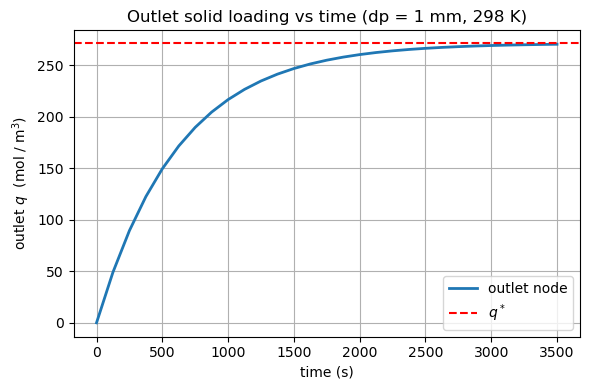

In [46]:
# Outlet node loading vs time
q_out  = np.array([profile[-1] for profile in q_histB])   # last cell = outlet
time_s = np.array(time_histB)
q_star_valB = q_star_func(cB)

plt.figure(figsize=(6,4))
plt.plot(time_s, q_out, lw=2, label="outlet node")

plt.axhline(q_star_valB[-1], ls="--", c="red", label=r"$q^*$")

plt.xlabel("time (s)")
plt.ylabel(r"outlet $q$  (mol / m$^{3}$)")
plt.title("Outlet solid loading vs time (dp = 1 mm, 298 K)")
plt.legend(); plt.grid(True); plt.tight_layout()

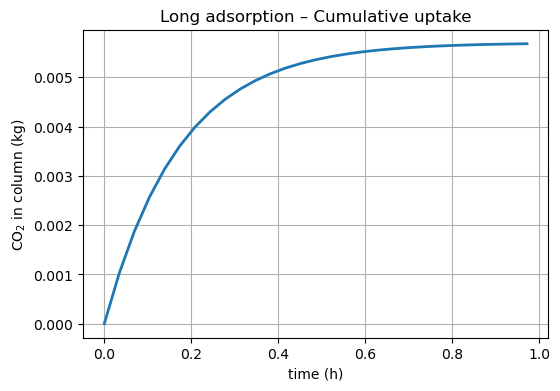

In [48]:
# Cumulative kg CO2 vs time
plt.figure(figsize=(6,4))
plt.plot(np.array(time_histB)/3600, kg_histB, lw=2)
plt.xlabel("time (h)")
plt.ylabel("CO$_2$ in column (kg)")
plt.title("Long adsorption – Cumulative uptake")
plt.grid(True)

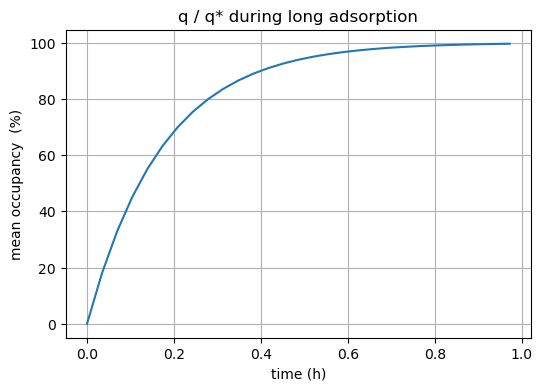

In [50]:
# Average pore-occupancy vs time
plt.figure(figsize=(6,4))
plt.plot(np.array(time_histB)/3600, occ_histB)
plt.xlabel("time (h)")
plt.ylabel("mean occupancy  (%)")
plt.title("q / q* during long adsorption")
plt.grid(True)

In [52]:
# Desorption Process 
# Calculate new 'k'
dpore = 14e-9 # m
DK_d = (dpore/3.0) * np.sqrt(8*R_mol*Twf/(np.pi*0.044009)) # Knudsen Diffusivity
D_TRI_d = DK_d/3 # where 3 is the tortiousity (Sabatino & Stampi-Bombelli)
De_p_d = D_TRI_d  # m2/s Effective pore diffusivity in TRI-al during desorption

Dm_d = Dm * (Twf / Tc)**1.5 * (pH / pL)  # m2/s molecular diffusivity during desorption 
v_d = 0.0 # m/s during desorption
u_d = v_d / epsilon # m/s interstitial velocity during desorption

rho_d = CP.PropsSI('D','P',pL,'T',Twf,'air') #kg/m3 constant density
mu_d = CP.PropsSI('V','P',pL,'T',Twf,'air') #Pa*s constant viscosity
Re_d = rho_d * v_d * dp / mu_d # Reynolds number
Sc_d = mu_d / (rho_d * Dm_d) # Schmidt number

ks = 10**4 # assumed for now, Stampi-Bombelli

Sh_d = 2 + 1.1 * Re_d**0.6 * Sc_d**0.33 # Sherwood number
kf_prime_d = Dm_d / dp * Sh_d # m/s
kf_d = 3 / rp * kf_prime_d  # 1/s

kp_d = 15 * epsilon_p * De_p_d / (rp**2)  # 1/s

qv_star_d = q_star_des * rho_bed * psi # mol/m3 (mol/kg * kg/m3)
c_CO2_d = (pCO2_des * 1000) / (R_mol * Twf) # mol/m3 

k_inv_d = (1 / kf_d) * (qv_star_d / c_CO2_d) + (1 / kp_d) * (qv_star_d / c_CO2_d) + (1 / ks)
k_d = 1/k_inv_d

# print(kf_d,kp_d,k_d)
# print(kf,kp,k)

# print(Dm_d)


In [62]:
# Coupled PDE: Desorption from full

nx_d = 100 # number of spatial points
dx_d = L / nx_d
mesh_d = Grid1D(dx=dx_d, nx=nx_d) # use 1D grid to align with paper assumption


# Variables
c_d = CellVariable(name="Gas Concentration", mesh=mesh_d, value=0.0) # mol/m3 Gas phase concentration: initially 0 everywhere
q_d = CellVariable(name="Solid Loading", mesh=mesh_d, value=q_star_ads_c) # mol/m3 Solid phase concentration: initially full everywhere


# Inlet CO2 concentration (mol/m3)
c_in_des = (pCO2_des * 1000) / (R_mol * Twf) # mol/m3 

# Boundary conditions: Serna-Guerro paper
c_d.constrain(c_in_des, mesh_d.facesRight) # CO2 air value fixed 1kPa vacuum
c_d.faceGrad.constrain(0.0, mesh_d.facesLeft) # zero concentration gradient at outlet

v_vector_d = FaceVariable(mesh=mesh_d, rank=1, value=-v_d) # velocity in opposite direction

# PDE
mass_balance_d = (TransientTerm(coeff=epsilon_star, var=c_d)
                == DiffusionTerm(coeff=epsilon * Dm_d, var=c_d)
                - (1 - epsilon_star) * TransientTerm(var=q_d))


# Time loop
dt_d = 0.001
steps_d = 1000
x_d = mesh_d.cellCenters.value[0]
c_hist_d = [] # gas-phase CO2 concentration over time
q_hist_d = [] # solid-phase CO2 loading over time
time_hist_d = []


for step in range(steps_d):
    mass_balance_d.solve(var=c_d, dt=dt_d)
    q_d.setValue(q_d.value + k_d * (q_star_des - q_d.value) * dt_d)

    if step % 100 == 0:
        c_hist_d.append(c_d.value.copy())
        q_hist_d.append(q_d.value.copy())
        time_hist_d.append(step * dt_d)
        

In [63]:
# np.savez(
#     "PB_desorb.npz",
#     q=q_d.value,
#     c=c_d.value,
#     c_hist=c_hist_d,
#     q_hist=q_hist_d,
#     time_hist=time_hist_d,
#     x=x_d,
# )

data_des = np.load('PB_desorb.npz')
q_d = data_des['q'] # final solid loading profile
c_d = data_des['c'] # final gas concentration profile
q_hist_d = data_des['q_hist'] # time history of q profiles
c_hist_d = data_des['c_hist'] # time history of c profiles
time_hist_d = data_des['time_hist'] # time stamps
x_d = data_des['x'] # spatial grid


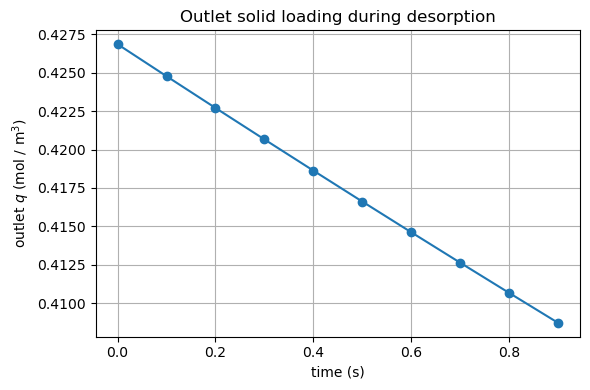

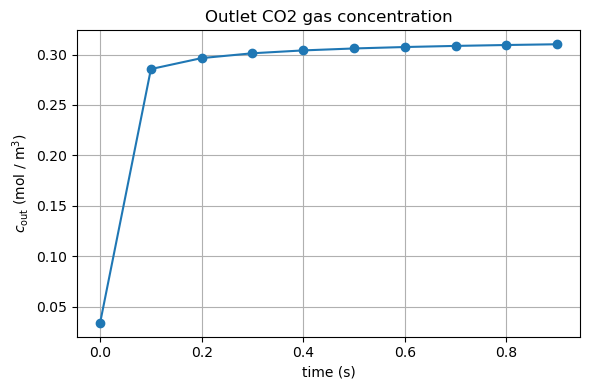

In [64]:
time_arr   = np.array(time_hist_d)
q_out_arr  = np.array([q[-1] for q in q_hist_d]) # outlet cell, mol/m3
c_out_arr = np.array([c[-1] for c in c_hist_d])

# outlet solid loading
plt.figure(figsize=(6,4))
plt.plot(time_arr, q_out_arr, marker='o')
plt.xlabel('time (s)')
plt.ylabel(r'outlet $q$ (mol / m$^{3}$)')
plt.title('Outlet solid loading during desorption')
plt.grid(True); plt.tight_layout()

# CO2 gas concentration at outlet
plt.figure(figsize=(6,4))
plt.plot(time_arr, c_out_arr, marker='o')
plt.xlabel('time (s)')
plt.ylabel(r'$c_{\mathrm{out}}$ (mol / m$^{3}$)')
plt.title('Outlet CO2 gas concentration')
plt.grid(True); plt.tight_layout()



In [67]:
# # Coupled PDE: Desorption from full longer time

# nx_dA = 20
# dx_dA = L / nx_dA
# mesh_dA = Grid1D(dx=dx_dA, nx=nx_dA)

# c_dA = CellVariable(name="Gas Concentration", mesh=mesh_dA, value=0.0)
# q_dA = CellVariable(name="Solid Loading", mesh=mesh_dA, value=q_star_ads_c)

# c_in_des = (pCO2_des * 1000) / (R_mol * Twf) # mol/m3 

# c_dA.constrain(c_in_des, mesh_dA.facesRight)
# c_dA.faceGrad.constrain(0.0, mesh_dA.facesLeft)

# v_vector_dA = FaceVariable(mesh=mesh_dA, rank=1, value=-v_d)

# mass_balance_dA = (TransientTerm(coeff=epsilon_star, var=c_dA)
#                 == DiffusionTerm(coeff=epsilon * Dm_d, var=c_dA)
#                 - (1 - epsilon_star) * TransientTerm(var=q_dA))

# dt_dA = 0.025
# steps_dA = 48000 # 20 minutes desorption
# x_dA = mesh_dA.cellCenters.value[0]

# c_hist_dA = []
# q_hist_dA = []
# time_hist_dA = []

# for step in range(steps_dA):
#     mass_balance_dA.solve(var=c_dA, dt=dt_dA)
#     q_dA.setValue(q_dA.value + k_d * (q_star_des - q_dA.value) * dt_dA)

#     if step % 100 == 0:
#         c_hist_dA.append(c_dA.value.copy())
#         q_hist_dA.append(q_dA.value.copy())
#         time_hist_dA.append(step * dt_dA)

# np.savez(
#     "PB_desorption_long.npz",
#     q=q_dA.value,
#     c=c_dA.value,
#     q_hist=q_hist_dA,
#     c_hist=c_hist_dA,
#     time_hist=time_hist_dA,
#     x=x_dA,
# )


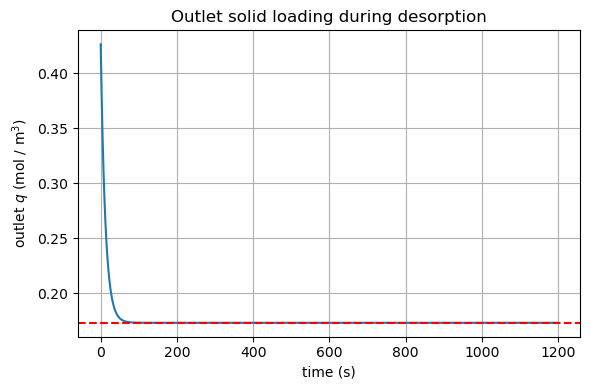

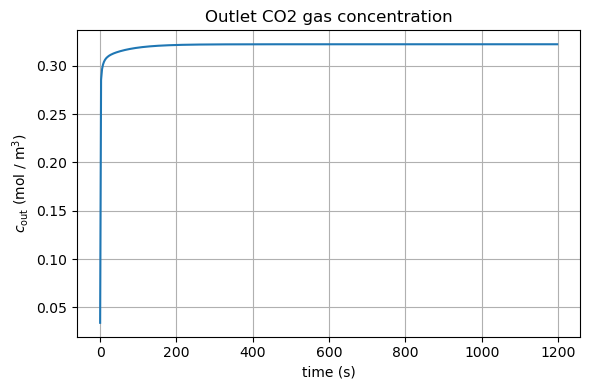

In [69]:
data_desA = np.load("PB_desorption_long.npz")

q_dA        = data_desA["q"]
c_dA        = data_desA["c"]
q_hist_dA   = data_desA["q_hist"]
c_hist_dA   = data_desA["c_hist"]
time_hist_dA = data_desA["time_hist"]
x_dA        = data_desA["x"]


time_arrA   = np.array(time_hist_dA)
q_out_arrA  = np.array([qA[-1] for qA in q_hist_dA]) # outlet cell, mol/m3
c_out_arrA = np.array([cA[-1] for cA in c_hist_dA])

# outlet solid loading
plt.figure(figsize=(6,4))
plt.plot(time_arrA, q_out_arrA)
plt.axhline(q_star_des, ls="--", c="red", label=r"$q^*$")
plt.xlabel('time (s)')
plt.ylabel(r'outlet $q$ (mol / m$^{3}$)')
plt.title('Outlet solid loading during desorption')
plt.grid(True); plt.tight_layout()

# CO2 gas concentration at outlet
plt.figure(figsize=(6,4))
plt.plot(time_arrA, c_out_arrA)
plt.xlabel('time (s)')
plt.ylabel(r'$c_{\mathrm{out}}$ (mol / m$^{3}$)')
plt.title('Outlet CO2 gas concentration')
plt.grid(True); plt.tight_layout()


In [76]:
# # Coupled PDE: Desorption from where adsorption B left off

# nx_dB = 20
# dx_dB = L / nx_dB
# mesh_dB = Grid1D(dx=dx_dB, nx=nx_dB)

# c_dB = CellVariable(name="Gas Concentration", mesh=mesh_dB, value=0.0)
# q_dB = CellVariable(name="Solid Loading", mesh=mesh_dB, value=q_histB[-1].copy())

# c_in_des = (pCO2_des * 1000) / (R_mol * Twf) # mol/m3 

# c_dB.constrain(c_in_des, mesh_dB.facesRight)
# c_dB.faceGrad.constrain(0.0, mesh_dB.facesLeft)

# v_vector_dB = FaceVariable(mesh=mesh_dB, rank=1, value=-v_d)

# mass_balance_dB = (TransientTerm(coeff=epsilon_star, var=c_dB)
#                 == DiffusionTerm(coeff=epsilon * Dm_d, var=c_dB)
#                 - (1 - epsilon_star) * TransientTerm(var=q_dB))

# dt_dB = 0.025
# steps_dB = 48000 # 20 minutes desorption
# x_dB = mesh_dB.cellCenters.value[0]

# c_hist_dB = []
# q_hist_dB = []
# time_hist_dB = []

# for step in range(steps_dB):
#     mass_balance_dB.solve(var=c_dB, dt=dt_dB)
#     q_dB.setValue(q_dB.value + k_d * (q_star_des - q_dB.value) * dt_dB)

#     if step % 100 == 0:
#         c_hist_dB.append(c_dB.value.copy())
#         q_hist_dB.append(q_dB.value.copy())
#         time_hist_dB.append(step * dt_dB)

# np.savez(
#     "PB_desorption_from_adsB.npz",
#     q=q_dB.value,
#     c=c_dB.value,
#     q_hist=q_hist_dB,
#     c_hist=c_hist_dB,
#     time_hist=time_hist_dB,
#     x=x_dB,
# )


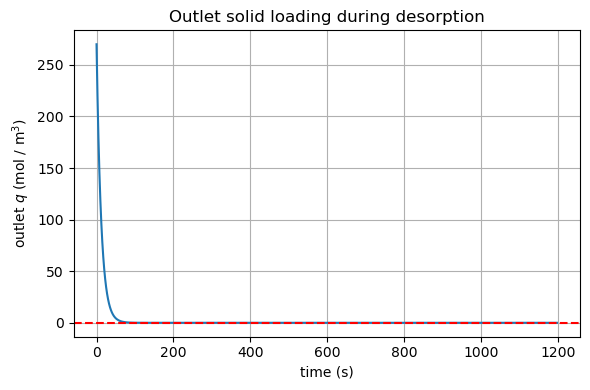

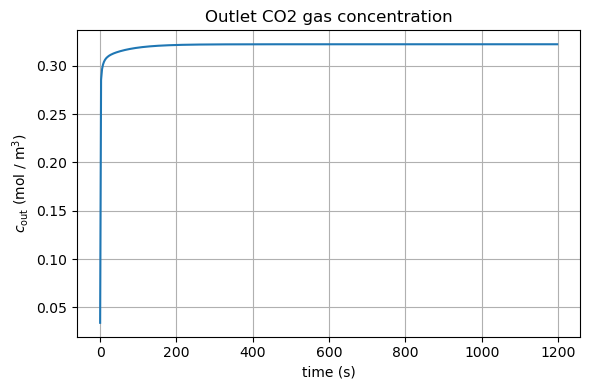

In [78]:
data_desB = np.load("PB_desorption_from_adsB.npz")

q_dB        = data_desB["q"]
c_dB        = data_desB["c"]
q_hist_dB   = data_desB["q_hist"]
c_hist_dB   = data_desB["c_hist"]
time_hist_dB = data_desB["time_hist"]
x_dB        = data_desB["x"]


time_arrB  = np.array(time_hist_dB)
q_out_arrB  = np.array([qB[-1] for qB in q_hist_dB]) # outlet cell, mol/m3
c_out_arrB = np.array([cB[-1] for cB in c_hist_dB])

# outlet solid loading
plt.figure(figsize=(6,4))
plt.plot(time_arrB, q_out_arrB)
plt.axhline(q_star_des, ls="--", c="red", label=r"$q^*$")
plt.xlabel('time (s)')
plt.ylabel(r'outlet $q$ (mol / m$^{3}$)')
plt.title('Outlet solid loading during desorption')
plt.grid(True); plt.tight_layout()

# CO2 gas concentration at outlet
plt.figure(figsize=(6,4))
plt.plot(time_arrB, c_out_arrB)
plt.xlabel('time (s)')
plt.ylabel(r'$c_{\mathrm{out}}$ (mol / m$^{3}$)')
plt.title('Outlet CO2 gas concentration')
plt.grid(True); plt.tight_layout()


In [ ]:
# Energy requirement calculations 10 min ads, 10 min des:
cap10_df = pd.read_csv("capture_10min.csv")
kgCO2_10series  = pd.Series(cap10_df.kg_CO2.values, index=cap10_df.Temp_K.astype(int))

records_10 = []
for T_ran in range(270,322,2):
    
    mu   = CP.PropsSI('V', 'T', T_ran, 'P', pH, 'air')
    rho  = CP.PropsSI('D', 'T', T_ran, 'P', pH, 'air')
    
    t_fan = 600 # s, 10 min step 1
    t_comp1 = 50 # s, 50 from step 2
    t_heat = 600 # s, 10 min step 3
    t_comp2 = t_heat # s, step 3 vacuum pulling CO2 during desorption

    V_air = epsilon * V # m3, volume of air in packed bed (free space)
    area_air = V_air / L
    V_flow = area_air * v  # m3/s, Volumetric flow rate of gas
    m_air = rho * V_air # kg, mass of air in PB
    n_air = m_air / t_comp1  # kg/s, gas flow rate: mass of air / run time of vacuum pump

    m_CO2 = kgCO2_10series.loc[T_ran] # kg
    pCO2 = m_CO2 * R_CO2 * Twf/ V_air # Pa, partial pressure of CO2
    n_CO2 = m_CO2 / t_comp2 # kg/s, CO2 gas flow rate

    # Pressure Drop: Ergun Equation
    P_drop = (150 * (v * mu * (1 - epsilon)**2 * L) / ((dp)**2 * epsilon**3)) + (1.75 * (v**2 * rho * (1 - epsilon) * L) / (dp * epsilon**3))

    # Calculate work
    fanWork = fan_work(eta_fan, V_flow, P_drop, t_fan)
    compWork1 = comp_work(eta_comp, n_air, R, T_ran, pH, pL, t_comp1)
    compWork2 = comp_work(eta_comp, n_CO2, R_CO2, Twf, pCO2, pL, t_comp2)
    compWork = compWork1 + compWork2
    elecwork = total_work(compWork, fanWork)

    # Calculate heat transfer
    Q = heat_transfer(h_W, Twf, T_ran, r, L, t_heat)

    records_10.append(dict(Fan_work = fanWork, Comp_work1 = compWork1, Comp_work2 = compWork2, Heat = Q))
    
df_10 = pd.DataFrame(records_10)
print(df_10)


       Fan_work  Comp_work1   Comp_work2          Heat
0   5175.019376  301.858762  7751.578880  31109.307093
1   5168.627852  301.850788  7653.188889  30506.121303
2   5162.495630  301.843043  7551.004314  29902.935514
3   5156.616413  301.835521  7445.043558  29299.749724
4   5150.984090  301.828213  7335.326128  28696.563935
5   5145.592735  301.821112  7221.872700  28093.378145
6   5140.436597  301.814212  7104.705181  27490.192356
7   5135.510097  301.807505  6981.899263  26887.006566
8   5130.807818  301.800985  6855.434562  26283.820777
9   5126.324502  301.794647  6723.397963  25680.634988
10  5122.055042  301.788484  6583.894908  25077.449198
11  5117.994480  301.782491  6440.844681  24474.263409
12  5114.137997  301.776662  6288.503005  23871.077619
13  5110.480914  301.770992  6132.714120  23267.891830
14  5107.018682  301.765477  5967.772725  22664.706040
15  5103.746880  301.760110  5795.683841  22061.520251
16  5100.661211  301.754888  5616.533844  21458.334461
17  5097.7

In [ ]:
# Energy requirement calculations 20 min ads, 20 min des:
cap20_df = pd.read_csv("capture_20min.csv")
kgCO2_20series  = pd.Series(cap20_df.kg_CO2.values, index=cap20_df.Temp_K.astype(int))

records_20 = []
for T_ran in range(270,322,2):
    
    mu   = CP.PropsSI('V', 'T', T_ran, 'P', pH, 'air')
    rho  = CP.PropsSI('D', 'T', T_ran, 'P', pH, 'air')
    
    t_fan = 1200 # s
    t_comp1 = 50 # s
    t_heat = 1200 # s
    t_comp2 = t_heat # s, step 3 vacuum pulling CO2 during desorption

    V_air = epsilon * V # m3, volume of air in packed bed (free space)
    area_air = V_air / L
    V_flow = area_air * v  # m3/s, Volumetric flow rate of gas
    m_air = rho * V_air # kg, mass of air in PB
    n_air = m_air / t_comp1  # kg/s, gas flow rate: mass of air / run time of vacuum pump

    m_CO2 = kgCO2_20series.loc[T_ran] # kg
    pCO2 = m_CO2 * R_CO2 * Twf/ V_air # Pa, partial pressure of CO2
    n_CO2 = m_CO2 / t_comp2 # kg/s, CO2 gas flow rate

    # Pressure Drop: Ergun Equation
    P_drop = (150 * (v * mu * (1 - epsilon)**2 * L) / ((dp)**2 * epsilon**3)) + (1.75 * (v**2 * rho * (1 - epsilon) * L) / (dp * epsilon**3))

    # Calculate work
    fanWork = fan_work(eta_fan, V_flow, P_drop, t_fan)
    compWork1 = comp_work(eta_comp, n_air, R, T_ran, pH, pL, t_comp1)
    compWork2 = comp_work(eta_comp, n_CO2, R_CO2, Twf, pCO2, pL, t_comp2)
    compWork = compWork1 + compWork2
    elecwork = total_work(compWork, fanWork)

    # Calculate heat transfer
    Q = heat_transfer(h_W, Twf, T_ran, r, L, t_heat)

    records_20.append(dict(Fan_work = fanWork, Comp_work1 = compWork1, Comp_work2 = compWork2, Heat = Q))
    
df_20 = pd.DataFrame(records_20)
print(df_20)


        Fan_work  Comp_work1    Comp_work2          Heat
0   10350.038753  301.858762  12388.069010  62218.614186
1   10337.255703  301.850788  12189.850093  61012.242607
2   10324.991260  301.843043  11983.717496  59805.871028
3   10313.232826  301.835521  11765.607694  58599.499449
4   10301.968179  301.828213  11537.647778  57393.127870
5   10291.185469  301.821112  11299.906690  56186.756291
6   10280.873194  301.814212  11048.373355  54980.384712
7   10271.020194  301.807505  10787.232905  53774.013133
8   10261.615636  301.800985  10512.508785  52567.641554
9   10252.649004  301.794647  10226.356775  51361.269975
10  10244.110084  301.788484   9926.879502  50154.898396
11  10235.988959  301.782491   9616.244528  48948.526817
12  10228.275994  301.776662   9290.585973  47742.155238
13  10220.961828  301.770992   8954.108810  46535.783659
14  10214.037364  301.765477   8605.002048  45329.412080
15  10207.493760  301.760110   8243.489735  44123.040501
16  10201.322422  301.754888   

In [ ]:
# Energy requirement calculations 30 min ads, 30 min des:
cap30_df = pd.read_csv("capture_30min.csv")
kgCO2_30series  = pd.Series(cap30_df.kg_CO2.values, index=cap30_df.Temp_K.astype(int))

records_30 = []
for T_ran in range(270,322,2):
    
    mu   = CP.PropsSI('V', 'T', T_ran, 'P', pH, 'air')
    rho  = CP.PropsSI('D', 'T', T_ran, 'P', pH, 'air')
    
    t_fan = 1800 # s
    t_comp1 = 50 # s
    t_heat = 1800 # s
    t_comp2 = t_heat # s, step 3 vacuum pulling CO2 during desorption

    V_air = epsilon * V # m3, volume of air in packed bed (free space)
    area_air = V_air / L
    V_flow = area_air * v  # m3/s, Volumetric flow rate of gas
    m_air = rho * V_air # kg, mass of air in PB
    n_air = m_air / t_comp1  # kg/s, gas flow rate: mass of air / run time of vacuum pump

    m_CO2 = kgCO2_30series.loc[T_ran] # kg
    pCO2 = m_CO2 * R_CO2 * Twf/ V_air # Pa, partial pressure of CO2
    n_CO2 = m_CO2 / t_comp2 # kg/s, CO2 gas flow rate

    # Pressure Drop: Ergun Equation
    P_drop = (150 * (v * mu * (1 - epsilon)**2 * L) / ((dp)**2 * epsilon**3)) + (1.75 * (v**2 * rho * (1 - epsilon) * L) / (dp * epsilon**3))

    # Calculate work
    fanWork = fan_work(eta_fan, V_flow, P_drop, t_fan)
    compWork1 = comp_work(eta_comp, n_air, R, T_ran, pH, pL, t_comp1)
    compWork2 = comp_work(eta_comp, n_CO2, R_CO2, Twf, pCO2, pL, t_comp2)
    compWork = compWork1 + compWork2
    elecwork = total_work(compWork, fanWork)

    # Calculate heat transfer
    Q = heat_transfer(h_W, Twf, T_ran, r, L, t_heat)

    records_30.append(dict(Fan_work = fanWork, Comp_work1 = compWork1, Comp_work2 = compWork2, Heat = Q))
    
df_30 = pd.DataFrame(records_30)
print(df_30)

        Fan_work  Comp_work1    Comp_work2          Heat
0   15525.058129  301.858762  14838.857165  93327.921279
1   15505.883555  301.850788  14567.676649  91518.363910
2   15487.486891  301.843043  14282.323279  89708.806542
3   15469.849238  301.835521  13980.801983  87899.249173
4   15452.952269  301.828213  13665.318710  86089.691805
5   15436.778204  301.821112  13331.824484  84280.134436
6   15421.309791  301.814212  12982.552799  82470.577068
7   15406.530291  301.807505  12617.658469  80661.019699
8   15392.423454  301.800985  12235.246744  78851.462331
9   15378.973506  301.794647  11837.580224  77041.904963
10  15366.165126  301.788484  11424.863080  75232.347594
11  15353.983439  301.782491  10995.277788  73422.790226
12  15342.413991  301.776662  10553.162857  71613.232857
13  15331.442742  301.770992  10096.741040  69803.675489
14  15321.056046  301.765477   9630.342155  67994.118120
15  15311.240640  301.760110   9152.234598  66184.560752
16  15301.983633  301.754888   

In [ ]:
# Energy requirement calculations 1 hr ads, 1 hr des:
cap1h_df = pd.read_csv("capture_1hr.csv")
kgCO2_1hseries  = pd.Series(cap1h_df.kg_CO2.values, index=cap1h_df.Temp_K.astype(int))

records_1h = []
for T_ran in range(270,322,2):
    
    mu   = CP.PropsSI('V', 'T', T_ran, 'P', pH, 'air')
    rho  = CP.PropsSI('D', 'T', T_ran, 'P', pH, 'air')
    
    t_fan = 3600 # s
    t_comp1 = 50 # s
    t_heat = 3600 # s
    t_comp2 = t_heat # s, step 3 vacuum pulling CO2 during desorption

    V_air = epsilon * V # m3, volume of air in packed bed (free space)
    area_air = V_air / L
    V_flow = area_air * v  # m3/s, Volumetric flow rate of gas
    m_air = rho * V_air # kg, mass of air in PB
    n_air = m_air / t_comp1  # kg/s, gas flow rate: mass of air / run time of vacuum pump

    m_CO2 = kgCO2_1hseries.loc[T_ran] # kg
    pCO2 = m_CO2 * R_CO2 * Twf/ V_air # Pa, partial pressure of CO2
    n_CO2 = m_CO2 / t_comp2 # kg/s, CO2 gas flow rate

    # Pressure Drop: Ergun Equation
    P_drop = (150 * (v * mu * (1 - epsilon)**2 * L) / ((dp)**2 * epsilon**3)) + (1.75 * (v**2 * rho * (1 - epsilon) * L) / (dp * epsilon**3))

    # Calculate work
    fanWork = fan_work(eta_fan, V_flow, P_drop, t_fan)
    compWork1 = comp_work(eta_comp, n_air, R, T_ran, pH, pL, t_comp1)
    compWork2 = comp_work(eta_comp, n_CO2, R_CO2, Twf, pCO2, pL, t_comp2)
    compWork = compWork1 + compWork2
    elecwork = total_work(compWork, fanWork)

    # Calculate heat transfer
    Q = heat_transfer(h_W, Twf, T_ran, r, L, t_heat)

    records_1h.append(dict(Fan_work = fanWork, Comp_work1 = compWork1, Comp_work2 = compWork2, Heat = Q))
    
df_1h = pd.DataFrame(records_1h)
print(df_1h)

        Fan_work  Comp_work1    Comp_work2           Heat
0   31050.116259  301.858762  17106.467962  186655.842557
1   31011.767109  301.850788  16737.712572  183036.727821
2   30974.973781  301.843043  16346.384185  179417.613084
3   30939.698477  301.835521  15932.665288  175798.498347
4   30905.904538  301.828213  15498.869813  172179.383610
5   30873.556407  301.821112  15045.199939  168560.268873
6   30842.619583  301.814212  14569.776908  164941.154136
7   30813.060583  301.807505  14077.051532  161322.039399
8   30784.846909  301.800985  13565.184029  157702.924662
9   30757.947011  301.794647  13036.545787  154083.809925
10  30732.330252  301.788484  12495.571564  150464.695188
11  30707.966877  301.782491  11940.474925  146845.580451
12  30684.827982  301.776662  11375.683264  143226.465714
13  30662.885484  301.770992  10803.535475  139607.350977
14  30642.112092  301.765477  10228.383364  135988.236240
15  30622.481281  301.760110   9648.470800  132369.121503
16  30603.9672

In [ ]:
# Energy requirement calculations 5 min ads, 5 min des:
cap5_df = pd.read_csv("capture_5min.csv")
kgCO2_5series  = pd.Series(cap5_df.kg_CO2.values, index=cap5_df.Temp_K.astype(int))

records_5 = []
for T_ran in range(270,322,2):
    
    mu   = CP.PropsSI('V', 'T', T_ran, 'P', pH, 'air')
    rho  = CP.PropsSI('D', 'T', T_ran, 'P', pH, 'air')
    
    t_fan = 300 # s, 10 min step 1
    t_comp1 = 50 # s, 50 from step 2
    t_heat = 300 # s, 10 min step 3
    t_comp2 = t_heat # s, step 3 vacuum pulling CO2 during desorption

    V_air = epsilon * V # m3, volume of air in packed bed (free space)
    area_air = V_air / L
    V_flow = area_air * v  # m3/s, Volumetric flow rate of gas
    m_air = rho * V_air # kg, mass of air in PB
    n_air = m_air / t_comp1  # kg/s, gas flow rate: mass of air / run time of vacuum pump

    m_CO2 = kgCO2_5series.loc[T_ran] # kg
    pCO2 = m_CO2 * R_CO2 * Twf/ V_air # Pa, partial pressure of CO2
    n_CO2 = m_CO2 / t_comp2 # kg/s, CO2 gas flow rate

    # Pressure Drop: Ergun Equation
    P_drop = (150 * (v * mu * (1 - epsilon)**2 * L) / ((dp)**2 * epsilon**3)) + (1.75 * (v**2 * rho * (1 - epsilon) * L) / (dp * epsilon**3))

    # Calculate work
    fanWork = fan_work(eta_fan, V_flow, P_drop, t_fan)
    compWork1 = comp_work(eta_comp, n_air, R, T_ran, pH, pL, t_comp1)
    compWork2 = comp_work(eta_comp, n_CO2, R_CO2, Twf, pCO2, pL, t_comp2)
    compWork = compWork1 + compWork2
    elecwork = total_work(compWork, fanWork)

    # Calculate heat transfer
    Q = heat_transfer(h_W, Twf, T_ran, r, L, t_heat)

    records_5.append(dict(Fan_work = fanWork, Comp_work1 = compWork1, Comp_work2 = compWork2, Heat = Q))
    
df_5 = pd.DataFrame(records_5)
print(df_5)


       Fan_work  Comp_work1   Comp_work2          Heat
0   2587.509688  301.858762  4183.208424  15554.653546
1   2584.313926  301.850788  4137.185301  15253.060652
2   2581.247815  301.843043  4091.219147  14951.467757
3   2578.308206  301.835521  4045.310521  14649.874862
4   2575.492045  301.828213  3997.627187  14348.281967
5   2572.796367  301.821112  3948.177088  14046.689073
6   2570.218299  301.814212  3898.796204  13745.096178
7   2567.755049  301.807505  3847.660322  13443.503283
8   2565.403909  301.800985  3794.778426  13141.910388
9   2563.162251  301.794647  3740.160008  12840.317494
10  2561.027521  301.788484  3685.631167  12538.724599
11  2558.997240  301.782491  3627.567104  12237.131704
12  2557.068999  301.776662  3567.798181  11935.538810
13  2555.240457  301.770992  3506.336214  11633.945915
14  2553.509341  301.765477  3441.391536  11332.353020
15  2551.873440  301.760110  3374.787378  11030.760125
16  2550.330606  301.754888  3304.744355  10729.167231
17  2548.8

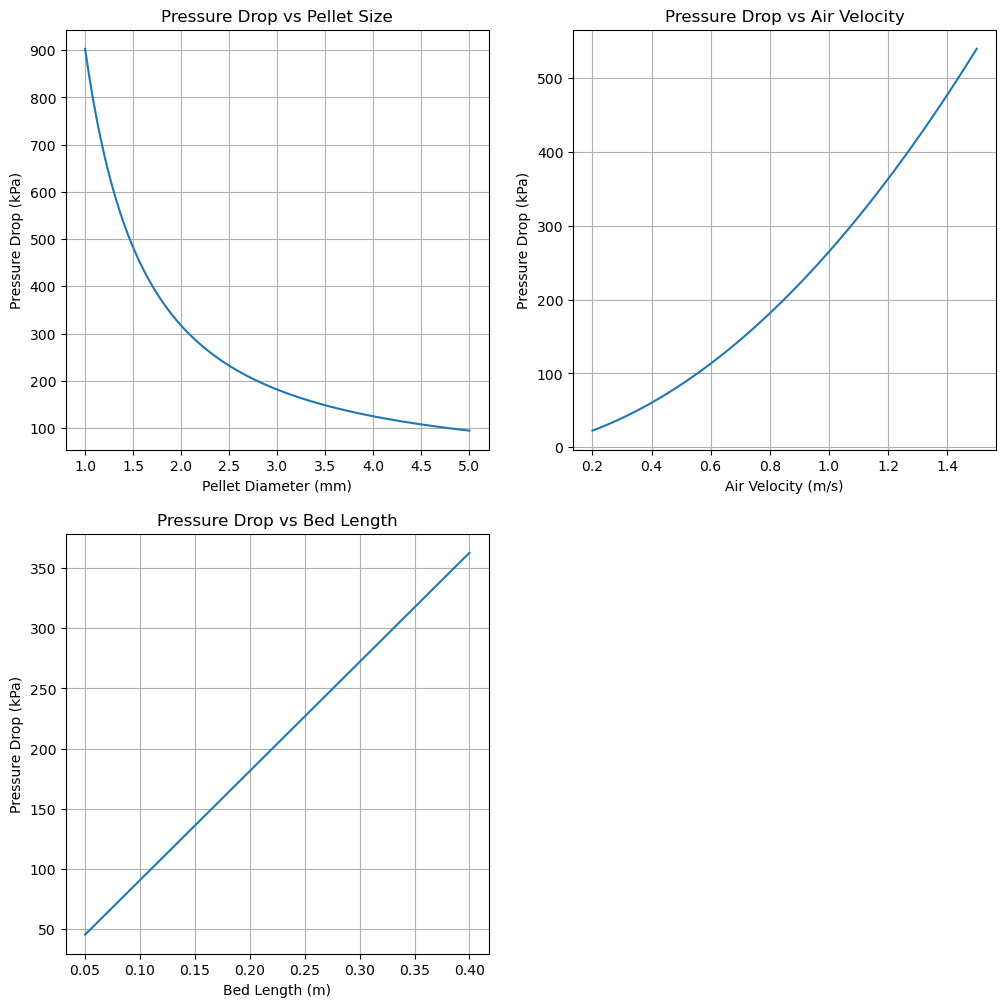

In [ ]:
## Packed Bed Pressure Drop Plots:
# Constants
mu_fixed = CP.PropsSI('V', 'P', 101325, 'T', 293, 'air')
rho_fixed = CP.PropsSI('D','P',101325,'T', 293,'air')
v_fixed = 0.8 # m/s, fixed velocity
L_fixed = 0.2 # m, fixed bed length
dp_fixed = 0.003 # 3 mm, fixed particle diameter

# Ergun equation function
def ergun_pressure_drop(mu, rho, epsilon, dp, v, L):
    deltaP = (150 * (v * mu * (1 - epsilon)**2 * L) / ((dp)**2 * epsilon**3)) + (1.75 * (v**2 * rho * (1 - epsilon) * L) / (dp * epsilon**3))
    return deltaP

# 1. Vary pellet size
dp_vals = np.linspace(0.001, 0.005, 100)  # 1–5 mm
P_dp = ergun_pressure_drop(mu_fixed, rho_fixed, epsilon, dp_vals, v_fixed, L_fixed)

# 2. Vary velocity
v_vals = np.linspace(0.2, 1.5, 100)
P_v = ergun_pressure_drop(mu_fixed, rho_fixed, epsilon, dp_fixed, v_vals, L_fixed)

# 3. Vary bed length
L_vals = np.linspace(0.05, 0.4, 100)
P_L = ergun_pressure_drop(mu_fixed, rho_fixed, epsilon, dp_fixed, v_fixed, L_vals)

# Plot 1: Pressure drop vs Pellet Size
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(dp_vals*1000, P_dp/1000)  # Convert x to mm, y to kPa
plt.xlabel('Pellet Diameter (mm)')
plt.ylabel('Pressure Drop (kPa)')
plt.title('Pressure Drop vs Pellet Size')
plt.grid(True)

# Plot 2: Pressure drop vs Air Velocity
plt.subplot(2, 2, 2)
plt.plot(v_vals, P_v/1000)
plt.xlabel('Air Velocity (m/s)')
plt.ylabel('Pressure Drop (kPa)')
plt.title('Pressure Drop vs Air Velocity')
plt.grid(True)

# Plot 3: Pressure drop vs Bed Length
plt.subplot(2, 2, 3)
plt.plot(L_vals, P_L/1000)
plt.xlabel('Bed Length (m)')
plt.ylabel('Pressure Drop (kPa)')
plt.title('Pressure Drop vs Bed Length')
plt.grid(True)
plt.show()


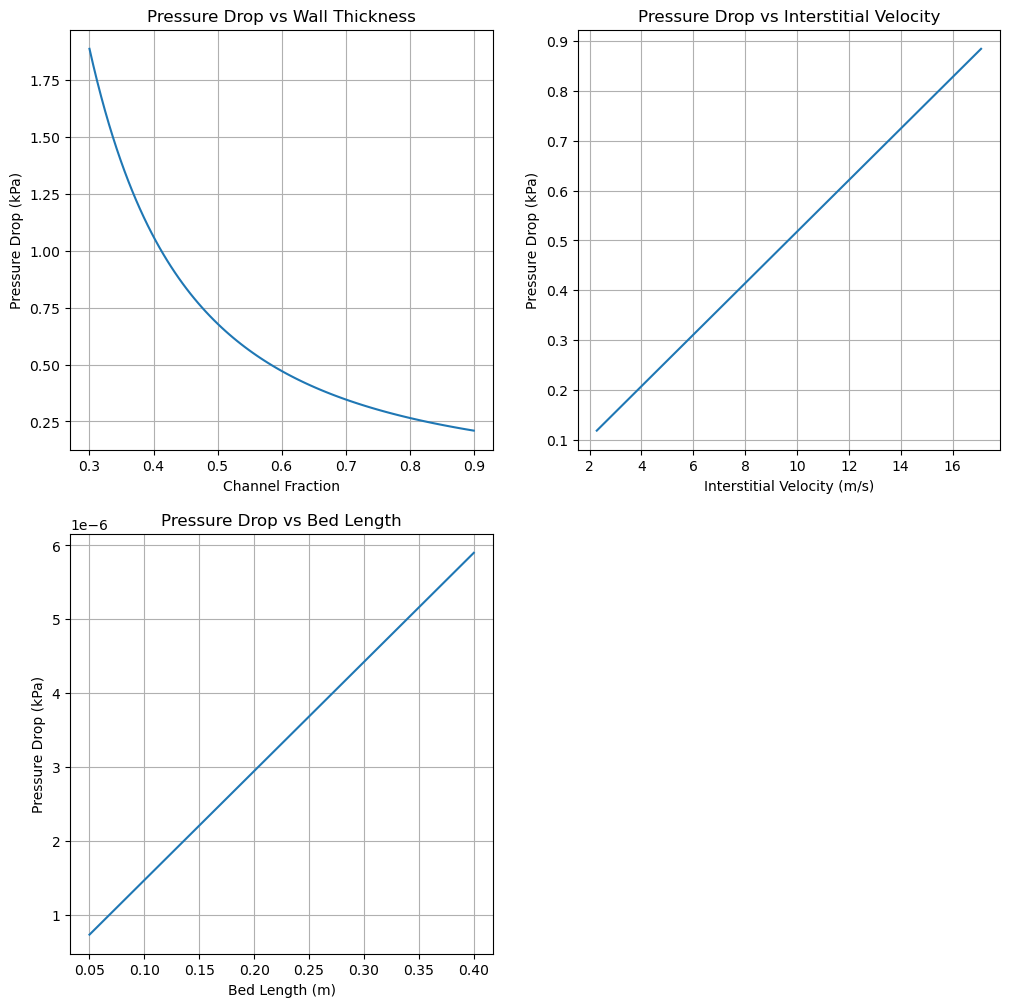

In [ ]:
## Monolith Pressure Drop 
# Constants
mu_fixed = CP.PropsSI('V', 'P', 101325, 'T', 293, 'air')
rho_fixed = CP.PropsSI('D','P',101325,'T', 293,'air')
v_fixed = 0.8 # m/s, fixed velocity
u_fixed = v_fixed / epsilon # fixed interstitial velocity
L_fixed = 0.2 # m, fixed channel length
w2_fixed = 0.0025 # m, 2.5mm cell width
w1_fixed = 0.6 # fix wall fraction at 60%

# Hagen-Poisueielle equation function
def hagen_poiseuille_pressure_drop(mu, u, L, w1):
    deltaP = (32 * L * mu * u) / (w1**2)
    return deltaP

# 1. Vary wall thickness
channel_fractions = np.linspace(0.3, 0.9, 100)  # 30-90% of channel is open (not wall)
w1 = w2_fixed * channel_fractions # m, wall thickness 
P_wall = hagen_poiseuille_pressure_drop(mu_fixed, u_fixed, L_fixed, w1)

# 2. Vary velocity
v_vals = np.linspace(0.2, 1.5, 100)
u_vals = v_vals / epsilon
P_u = hagen_poiseuille_pressure_drop(mu_fixed, u_vals, L_fixed, w2_fixed * w1_fixed)

# 3. Vary channel length
L_vals = np.linspace(0.05, 0.4, 100)
P_L = hagen_poiseuille_pressure_drop(mu_fixed, u_fixed, L_vals, w1_fixed)

# Plot 1: Pressure drop vs Wall thickness
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(wall_fractions, P_wall/1000)  # Convert x to mm, y to kPa
plt.xlabel('Channel Fraction')
plt.ylabel('Pressure Drop (kPa)')
plt.title('Pressure Drop vs Wall Thickness')
plt.grid(True)

# Plot 2: Pressure drop vs Interstitial Velocity
plt.subplot(2, 2, 2)
plt.plot(u_vals, P_u/1000)
plt.xlabel('Interstitial Velocity (m/s)')
plt.ylabel('Pressure Drop (kPa)')
plt.title('Pressure Drop vs Interstitial Velocity')
plt.grid(True)

# Plot 3: Pressure drop vs Channel Length
plt.subplot(2, 2, 3)
plt.plot(L_vals, P_L/1000)
plt.xlabel('Bed Length (m)')
plt.ylabel('Pressure Drop (kPa)')
plt.title('Pressure Drop vs Bed Length')
plt.grid(True)
plt.show()

In [80]:
print(k,kp)

0.0016017350014937949 25.56
